## Data cleaning and transforming

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
# load dataset - not uploaded with project for reasons of non-disclosure
df = pd.read_csv('./dataset_for_analyst_assignment_20201120.csv')

### First look through dataset - inspect what needs to be cleaned or transformed

In [3]:
from pandas_profiling import ProfileReport
# ProfileReport(df) - commented out for reasons of anonymity 

#### A look at the Profile Report resulted in the following relevant insights for the next steps:
- **Duplicates:** No duplicate rows -> No further step required
- **Missing values:** Many NaNs that could be represented by "0" (Step 2)
- **Noise:** Unnecessary characters can be removed of the strings of variables (Step 3)
- **PURCHASE_COUNT_BY_STORE_TYPE** dictionary should be exploded to columns to make it analyzable (Step 4)
- **Drop columns** that don't contain enough valuable information for the business case (Step 5)
- **Inactive users** The dataset provides a lot of information on users who have ordered at least one time but no information on users who have not ordered anything yet.
    - Split dataframe into a dataframe of users with purchase_count > 0 and a dataframe of users with purchase_count = 0 (Step 6)

### Handle missing values

In [4]:
# Clean PURCHASE_COUNT_DELIVERY and PURCHASE_COUNT_TAKEAWAY columns

# Does the sum of PURCHASE_COUNT_DELIVERY and PURCHASE_COUNT_TAKEAWAY equal the sum of purchase_count?
print(df['PURCHASE_COUNT_DELIVERY'].sum() + df['PURCHASE_COUNT_TAKEAWAY'].sum() == df['PURCHASE_COUNT'].sum()) 
# True --> No missing values, assuming that the values are correct and add up

True


In [5]:
# Clean all columns, where NaN can be reasonably filled by 0
# Fill all NaN values with '0'
NaN_variables = ['PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY', 
                 'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES',
                 'DINNER_PURCHASES', 'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR', 
                 'DISTINCT_PURCHASE_VENUE_COUNT', 'MIN_PURCHASE_VALUE_EUR',
                 'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 'IOS_PURCHASES', 
                 'WEB_PURCHASES', 'ANDROID_PURCHASES']
df[NaN_variables] =\
df[NaN_variables].fillna(0)

### Remove unnecessary characters in categorical variables

In [6]:
# Bring "PURCHASE_COUNT_BY_STORE_TYPE" into usable format
df['PURCHASE_COUNT_BY_STORE_TYPE'] = df['PURCHASE_COUNT_BY_STORE_TYPE'].str.replace('\n  ','').str.replace('\n','')

In [7]:
# Clean PREFERRED_RESTAURANT_TYPES from unnecessary charakters
df['PREFERRED_RESTAURANT_TYPES'] = df['PREFERRED_RESTAURANT_TYPES'].str.replace('\n  ','').str.replace('\n','')

### Explode dicts of  'PURCHASE_COUNT_BY_STORE_TYPE' to columns to make them analyzable

In [8]:
# Split PURCHASE_COUNT_BY_STORE_TYPE into analyzable columns and merge dataframes
df_storetype = pd.DataFrame(df['PURCHASE_COUNT_BY_STORE_TYPE'].apply(lambda x: eval(x)).to_list())
df = pd.concat([df, df_storetype], axis=1)
df = df.rename(columns={'General merchandise': 'GENERAL_MERCHANDISE_COUNT',
                        'Grocery': 'GROCERY_COUNT', 
                        'Pet supplies': 'PET_SUPPLIES_COUNT', 
                        'Restaurant': 'RESTAURANT_COUNT', 
                        'Retail store': 'RETAIL_STORE_COUNT'})

### Drop columns that don't contain valuable enough information for the business case

In [9]:
# Drop PURCHASE_COUNT_BY_STORE_TYPE as its values are now represented by other columns

# Drop LATE_NIGHT_PURCHASES because either no one has ordered at this time or the orders have not been recorded

# Drop USER_HAS_VALID_PAYMENT_METHOD under the assumption that they will update 
# their payment method when deciding to order something

# Drop REGISTRATION_COUNTRY under the assumption that the marketing team targets users individually based on the country they live in 
# or language they speak

# To limit the scope of the upcoming analyses, I decided to drop the following variables that are unlikely to be 
# key factors in my user segmentation
df = df.drop(columns=['PURCHASE_COUNT_BY_STORE_TYPE',
                      'LATE_NIGHT_PURCHASES', 
                      'USER_HAS_VALID_PAYMENT_METHOD', 
                      'REGISTRATION_COUNTRY', 
                      'REGISTRATION_DATE', 
                      'FIRST_PURCHASE_DAY', 
                      'LAST_PURCHASE_DAY'])

### Split dataframe into a dataframe of users with purchase_count > 0 and a dataframe of users with purchase_count = 0

In [10]:
df_purchases = df[df['PURCHASE_COUNT'] > 0].reset_index(drop=True)
df_nopurchases = df[df['PURCHASE_COUNT'] == 0].reset_index(drop=True)

## Exploratory analysis

### Inspecting both datasets after data cleaning

In [11]:
# ProfileReport(df_purchases) - commented out for reasons of anonymity 


In [12]:
# ProfileReport(df_nopurchases) - commented out for reasons of anonymity 

In [13]:
# Calculate percentage of mobile orders
precentage_mobile_orders = (df_purchases['IOS_PURCHASES'].sum() + df_purchases['ANDROID_PURCHASES'].sum()) / df_purchases['PURCHASE_COUNT'].sum()
# --> 83% of orders are taken via mobile device

#### Some insights from this inspection of the dataset
- **Inactive users:** Most variables of the dataframe with users who did not purchase anything don't contain relevant data to generate insights for our marketing team.
- **Distributions:** 
    - Categorical variables: Mostly equally distributed, except PREFERRED_DEVICE
    - Quantitative variables: Mostly skewed to the right with low values being the most represented
- **Outliers:** Many extreme values, deviating the mean by more than 3 standard deviations. However, this is expectable at this number of observations and the extreme values appear reasonable (i.e. max(TOTAL_PURCHASE_COUNT) = 320 --> Potentially by a customer who is very busy.) As most variables are also strongly skewed, it is recommendable to use the *median* rather than the mean to interpret variables.
- **PREFERRED_RESTAURANT_TYPES:** The most represented value is 'American', followed by 'Japanese' and 'Italian'. This can be used by the marketing team to tailor efficient advertisements. However, as this variable has too many missing values, we can not properly segment after this. This variable will be dropped, as more than 30% of values are missing and it is not further analyzable for our business case.
- **STORE_TYPES:** PET_SUPPLY and GENERAL_MERCHANDISE services rarely used. GROCERY and RETAIL_STORE are used more often (median = 0, mean_GROCERY = 1.06, mean_RETAIL_STORE = 1.21). RESTAURANTS remain the most frequently used service (median = 3, mean = 3.72)
- **Device:** 83% of orders are taken via mobile device. There are more IOS users than Android. The corresponding variables don't show strong correlations between any other variable. The marketing team should focus on targeting mobile users. These values are also corresponding to the distribution of PREFERRED_DEVICE.

In [14]:
# Drop PREFERRED_RESTAURANT_TYPES due to missing values
df_purchases = df_purchases.drop(columns = 'PREFERRED_RESTAURANT_TYPES')

# Drop variables considering device types
df_purchases = df_purchases.drop(columns = ['IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES'])

### Following analyses
1. **PURCHASE_COUNT:** As the task is to provide a user segmentation for the marketing team that helps to increase the activation rate of users. We want to increase the PURCHASE_COUNT. We therefore want to make inactive users active and increase the frequency of purchases for active users.
2. **Inactive users:** Should be targeted corresponding to the characteristics that best describe the average of the population that we have data on.
3. **Active users**: Find characteristics that distinguish highly active users from less active users. This can result in valuable insights for the marketing team to increase purchase frequency of the users.

Next steps:
1. **Inflated correlations:** Most potentially meaningful correlations are inflated as they are all strongly influenced by the PURCHASE_COUNT (i.e. The more purchases, the higher the count of other features). These absolute values should be transformed to relative values, so that actual meaningful correlations between the variables can be discovered.
2. **Exploratory analysis:** With relative values to identify factors that differentiat users that are highly active from users that are less active

#### Transform absolute to relative variables to decrease inflated correlations

In [15]:
# Variables to transform from absolute to relative value: 'PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY',
#        'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES',
#        'EVENING_PURCHASES', 'DINNER_PURCHASES',
#        'DISTINCT_PURCHASE_VENUE_COUNT',
#        'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES',
#        'GENERAL_MERCHANDISE_COUNT', 'GROCERY_COUNT', 'PET_SUPPLIES_COUNT',
#        'RESTAURANT_COUNT', 'RETAIL_STORE_COUNT'

df_purchases_transformed = df_purchases
to_transform = ['PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY',
                           'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES',
                           'EVENING_PURCHASES', 'DINNER_PURCHASES',
                           'GENERAL_MERCHANDISE_COUNT', 'GROCERY_COUNT', 
                           'PET_SUPPLIES_COUNT','RESTAURANT_COUNT', 
                           'RETAIL_STORE_COUNT', 'DISTINCT_PURCHASE_VENUE_COUNT']

df_purchases_transformed[to_transform] = df_purchases_transformed[to_transform].apply(lambda x: x/df_purchases_transformed['PURCHASE_COUNT'])

# Rename columns appropriately
df_purchases_transformed.rename(columns = {'PURCHASE_COUNT_DELIVERY': 'SHARE_PURCHASE_DELIVERY', 
                                           'PURCHASE_COUNT_TAKEAWAY': 'SHARE_PURCHASE_TAKEAWAY',
                                           'BREAKFAST_PURCHASES': 'SHARE_BREAKFAST_PURCHASES', 
                                           'LUNCH_PURCHASES': 'SHARE_LUNCH_PURCHASES',
                                           'EVENING_PURCHASES': 'SHARE_EVENING_PURCHASES', 
                                           'DINNER_PURCHASES': 'SHARE_DINNER_PURCHASES',
                                           'GENERAL_MERCHANDISE_COUNT': 'SHARE_GENERAL_MERCHANDISE', 
                                           'GROCERY_COUNT': 'SHARE_GROCERY', 
                                           'PET_SUPPLIES_COUNT': 'SHARE_PET_SUPPLIES',
                                           'RESTAURANT_COUNT': 'SHARE_RESTAURANT', 
                                           'RETAIL_STORE_COUNT': 'SHARE_RETAIL_STORE', 
                                           'DISTINCT_PURCHASE_VENUE_COUNT':'SHARE_DISTINCT_PURCHASE_VENUE'}, inplace = True)

#### Explore the new dataframe for factors that distinguish users with high activity from users with low activity

**Profile Report** for a general overview

In [16]:
# ProfileReport(df_purchases_transformed) - commented out for reasons of anonymity 


**Heatmap** to investigate correlations, especially with our target variable PURCHASE_COUNT

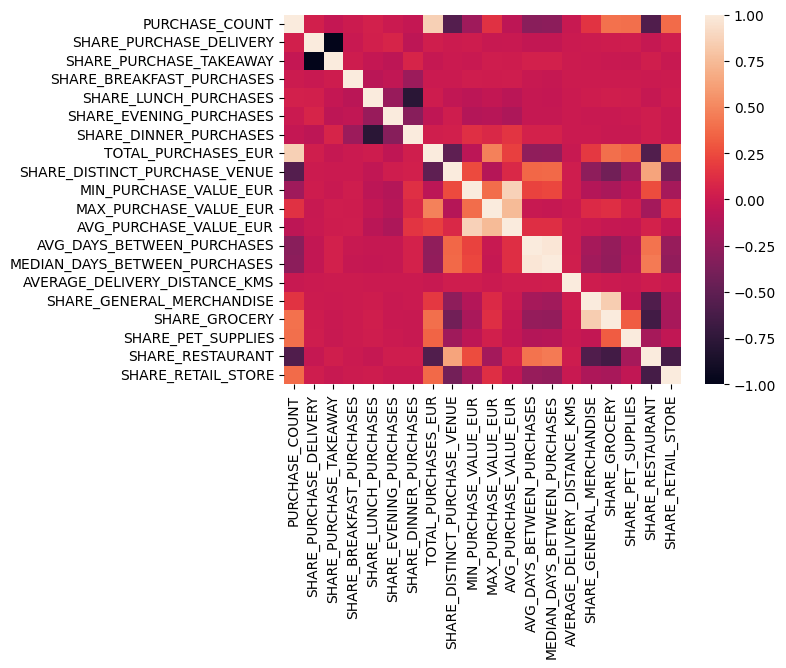

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
correlations =\
df_purchases_transformed.loc[:, ~df_purchases_transformed.columns.isin(['USER_ID',
                                                                        'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
                                                                        'MOST_COMMON_WEEKDAY_TO_PURCHASE'])].corr()
sns.heatmap(correlations)
plt.show()

- TOTAL_PURCHASES_EUR and PURCHASE_COUNT have the highest correlation but can be neglected as their relationship is obvious
- SHARE_RESTAURANT and PURCHASE_COUNT also have a relatively high correlation

**Scatterplot** to investigate the relationship between SHARE_RESTAURANT and PURCHASE_COUNT

In [18]:
import plotly.express as px
scatter = px.scatter(data_frame=df_purchases, y='PURCHASE_COUNT', x='SHARE_RESTAURANT', opacity=0.5, marginal_x="histogram", marginal_y="histogram")
scatter.show()

- Most people only order from Restaurants
- However, **any person with a PURCHASE_COUNT > 5 also uses other services.**

**Scatterplot** to visualize the relationship between SHARE_RESTAURANT, other services used and the corresponding PURCHASE_COUNT

In [19]:
df_purchases['SHARE_GROCERY_PET_MERCHANDISE_RETAIL'] =\
df_purchases['SHARE_GROCERY'] + df_purchases['SHARE_PET_SUPPLIES'] + df_purchases['SHARE_GENERAL_MERCHANDISE'] + df_purchases['SHARE_RETAIL_STORE']

scatter = px.scatter(data_frame=df_purchases, y='SHARE_GROCERY_PET_MERCHANDISE_RETAIL', x='SHARE_RESTAURANT', size='PURCHASE_COUNT', size_max = 100, opacity=0.3, marginal_x="histogram", marginal_y="histogram")
scatter.show()

### Analyses with segmented user groups

In [20]:
df_purchases_transformed_low = df_purchases_transformed[df_purchases_transformed['PURCHASE_COUNT'] < 6].reset_index(drop=True)
df_purchases_transformed_high = df_purchases_transformed[df_purchases_transformed['PURCHASE_COUNT']>= 6].reset_index(drop=True)

#### Inspection of quantitative variables

- Due to the clear behavioural difference from a PURCHASE_COUNT of 6 on, I decided to use this as a threshold to distinguish between highly active users and users that are less active

**Next steps:**
1. Conduct t-tests to see if there are significant differences on quantitative variables between the two groups
2. Plot the (significant) group differences to understand the relationships
3. Inspect the group differences of Categorical variables to check for additional potentially meaningful relationships

In [21]:
# Conduct independent samples t-tests to compare the two groups on the features of interest
from scipy import stats
features_of_interest = \
df_purchases_transformed_low.loc[:, ~df_purchases_transformed_low.columns.isin(['PURCHASE_COUNT',
                                                                                'PREFERRED_DEVICE',
                                                                                'USER_ID',
                                                                                'AVG_DAYS_BETWEEN_PURCHASES',
                                                                                'MEDIAN_DAYS_BETWEEN_PURCHASES', 
                                                                                'TOTAL_PURCHASES_EUR',
                                                                                'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
                                                                                'MOST_COMMON_WEEKDAY_TO_PURCHASE',
                                                                                'SHARE_GROCERY_PET_MERCHANDISE_RETAIL',
                                                                                'HIGH_ACTIVITY_USER' ])].columns

Ttests = pd.DataFrame(columns=['feature', 't-statistic', 'p-value'])
features = []
tstatistics = []
pvalues = []
mean_high_activity = []
mean_low_activity = []

for feature in features_of_interest:
    test = stats.ttest_ind(df_purchases_transformed_low[feature], df_purchases_transformed_high[feature])
    features.append(feature)
    tstatistics.append(test[0])
    pvalues.append(round(test[1],2))
    mean_low_activity.append(df_purchases_transformed_low[feature].mean())
    mean_high_activity.append(df_purchases_transformed_high[feature].mean())
    
Ttests = pd.DataFrame({'Feature': features, 't-statistic': tstatistics, 'p-value': pvalues, 'mean_low_users': mean_low_activity, 'mean_high_users': mean_high_activity})
Ttests.head()

/var/folders/yg/kt4pdk955453dzxyb3ppm5200000gn/T/ipykernel_6897/3118049105.py:23: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,Feature,t-statistic,p-value,mean_low_users,mean_high_users
0,SHARE_PURCHASE_DELIVERY,-2.695766,0.01,0.922393,0.934064
1,SHARE_PURCHASE_TAKEAWAY,2.695766,0.01,0.077607,0.065936
2,SHARE_BREAKFAST_PURCHASES,-0.185626,0.85,0.029801,0.030293
3,SHARE_LUNCH_PURCHASES,-3.286015,0.00,0.353534,0.378257
4,SHARE_EVENING_PURCHASES,1.710437,0.09,0.085629,0.078047


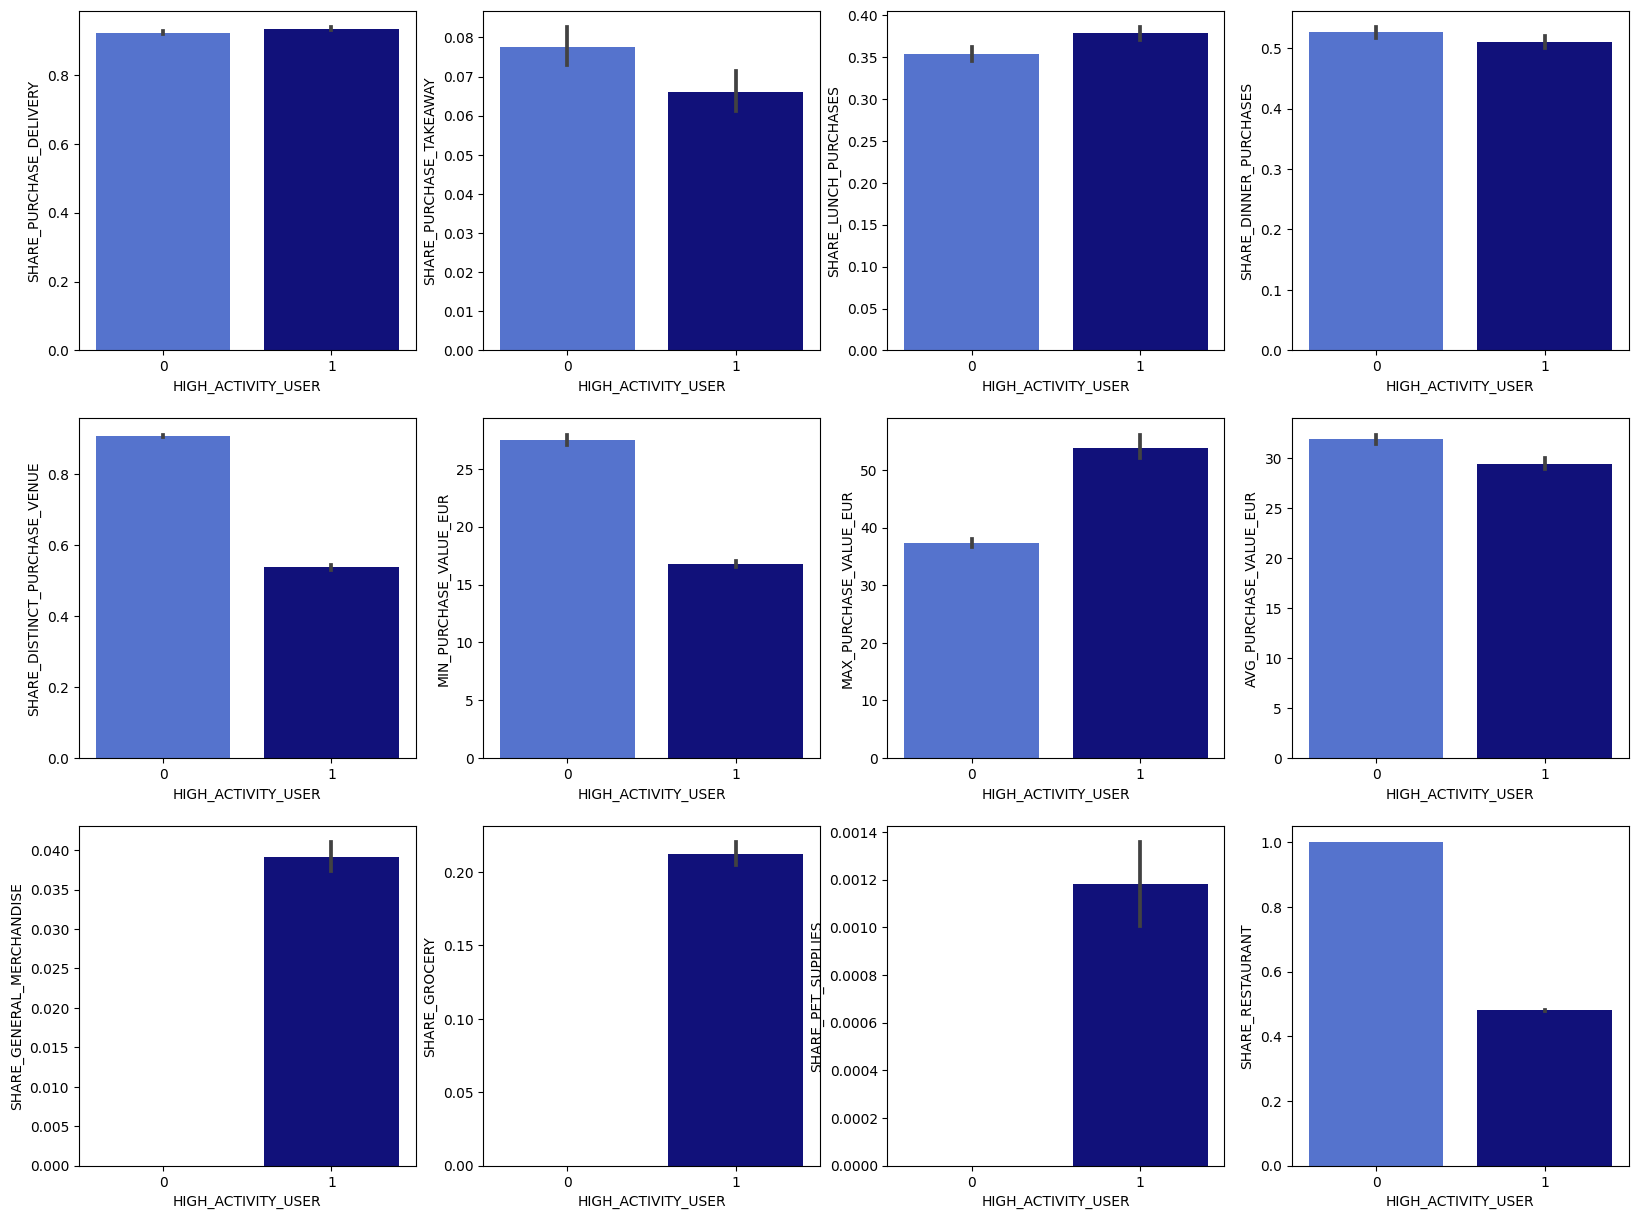

In [22]:
# Create Barplots to visualize the significant differences between the two groups
df_purchases_transformed['HIGH_ACTIVITY_USER'] = (df_purchases_transformed['PURCHASE_COUNT'] >=6).astype(int)
significant_features = Ttests[Ttests['p-value'] <= 0.05]['Feature']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize = (20,15))
color = ['royalblue', 'darkblue']

for feature, ax in zip(significant_features, axes.ravel()):
    sns.barplot(ax = ax, data = df_purchases_transformed, x= 'HIGH_ACTIVITY_USER', y= feature, palette=color)
plt.show()

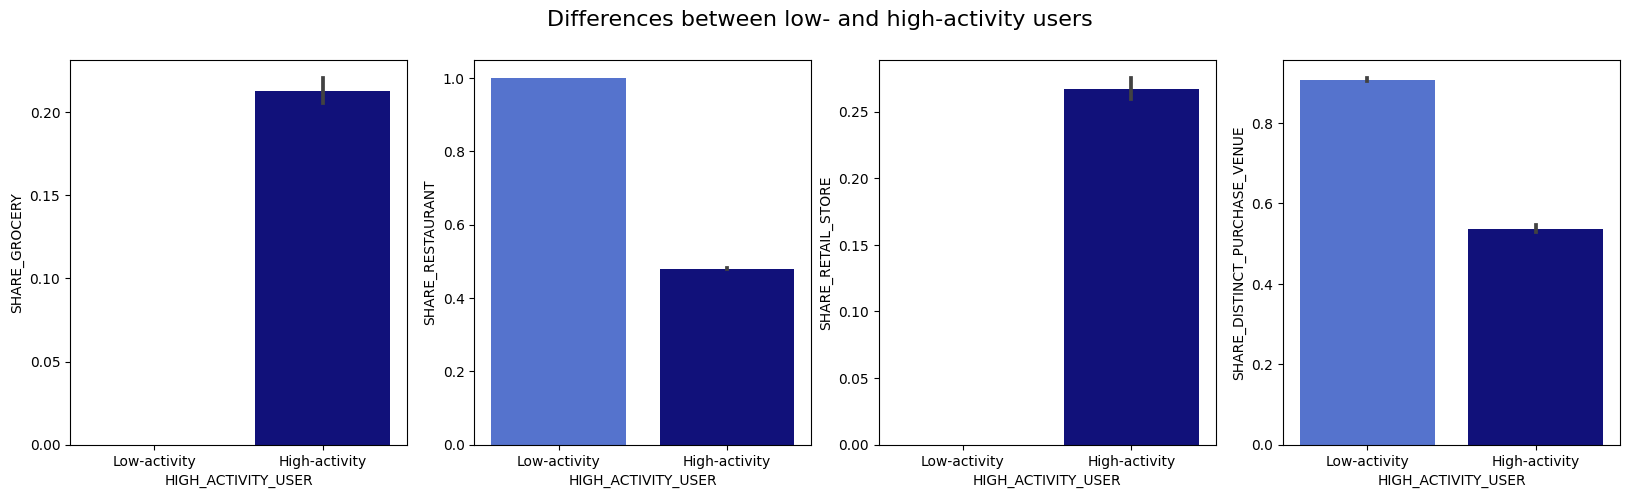

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
significant_features_presentation = ['SHARE_GROCERY','SHARE_RESTAURANT', 'SHARE_RETAIL_STORE', 'SHARE_DISTINCT_PURCHASE_VENUE']
for feature, ax in zip(significant_features_presentation, axes.ravel()):
    sns.barplot(ax = ax, data = df_purchases_transformed, x= 'HIGH_ACTIVITY_USER', y= feature, palette=color)\
    .set(xticklabels=["Low-activity", "High-activity"])

fig.suptitle('Differences between low- and high-activity users', fontsize=16)
plt.show()

**Some insights** from this inspection of the t-tests and corresponding plots
- At a significance level of $\alpha = .05$ several differences between the high and low activity users were found. Some are too small or arbitrary to result in meaningful suggestions for the marketing team. The ones with potential implications for the marketing team are the following:
    - SHARE_DISTINCT_PURCHASE_VENUE: In comparison to users with low activity, highly active users tend to use the same venues repeatedly.
    - AVG_PURCHASE_VALUE_EUR: Highly active users spend about 2.5 Euros less per order than users with low activity.
    - SHARE_GENERAL_MERCHANDISE: Low activity users don't use this type of service
    - SHARE_GROCERY: Low activity users don't use this type of service
    - SHARE_PET_SUPPLIES: Low activity users don't use this type of service
    - SHARE_RETAIL_STORE: Low activity users don't use this type of service
    - SHARE_RESTAURANT: Low activity users exlusively use the platform for restaurants, while only 48% of the orders of highly active users are for restaurants

#### Inspection of qualitative variables

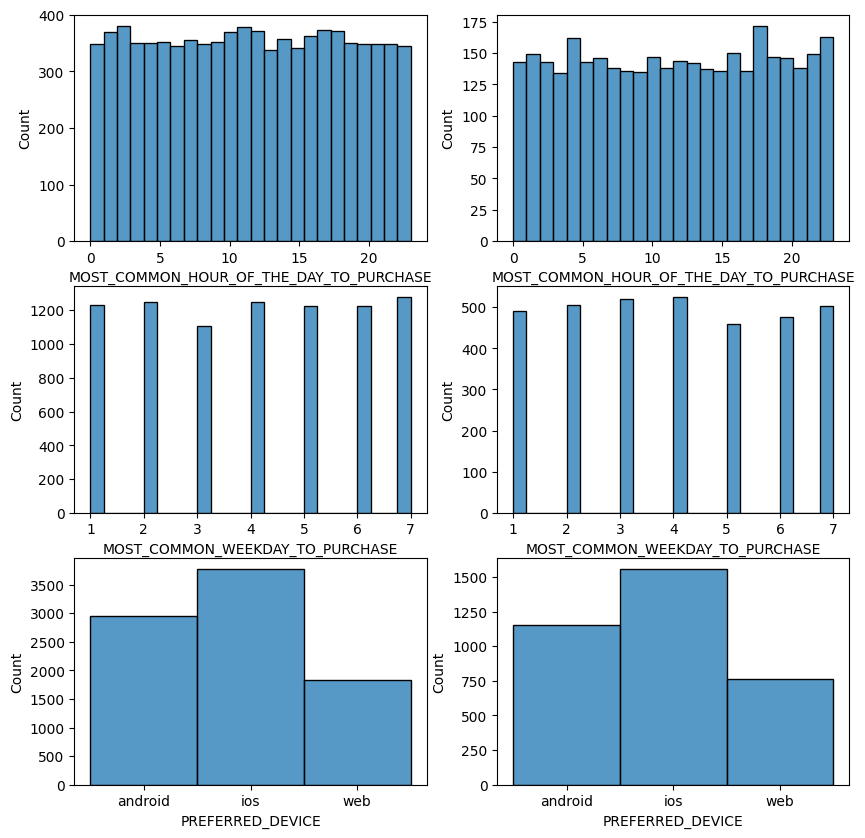

In [24]:
fig, axes = plt.subplots(3,2, figsize = (10,10))
categorical_features = ['MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE', 'MOST_COMMON_WEEKDAY_TO_PURCHASE', 'PREFERRED_DEVICE']

for feature, ax in zip(categorical_features, range(3)):
    sns.histplot(ax = axes[ax,0], data = df_purchases_transformed_low, x= feature, bins=24)
    sns.histplot(ax = axes[ax,1], data = df_purchases_transformed_high, x= feature, bins=24)
plt.show()

#### Order volume and potential revenue gain by segmented user groups

In [25]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

user_groups = ['Inactive users', 'Low-activity users', 'High-activity users']

count_user_groups = [df_nopurchases['USER_ID'].count(), 
                     df_purchases_transformed_low['USER_ID'].count(), 
                     df_purchases_transformed_high['USER_ID'].count()]

count_order_volume = [df_nopurchases['PURCHASE_COUNT'].sum(), 
                      df_purchases_transformed_low['PURCHASE_COUNT'].sum(), 
                      df_purchases_transformed_high['PURCHASE_COUNT'].sum()]

count_total_purchase_volume_eur = [df_nopurchases['TOTAL_PURCHASES_EUR'].sum(), 
                                   df_purchases_transformed_low['TOTAL_PURCHASES_EUR'].sum(), 
                                   df_purchases_transformed_high['TOTAL_PURCHASES_EUR'].sum()]

order_volume_df = pd.DataFrame({'User group': user_groups,
                                'Count': count_user_groups,
                                'Order volume': count_order_volume,
                                'Purchase volume': count_total_purchase_volume_eur})


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])


fig.add_trace(go.Pie(title='Number of users',
                     direction='clockwise',
                     labels=user_groups,
                     values=count_user_groups,
                     textinfo='value',
                     textposition='inside',
                     marker={'colors': ['lightcyan', 'royalblue', 'darkblue'],
                             'line': {'color': 'white', 'width': 1}}),row=1, col=1)

fig.add_trace(go.Pie(title='Purchases per user group',
                     direction='clockwise',
                     values=count_order_volume,
                     labels=user_groups,
                     textinfo='value',
                     textposition='inside',
                     marker={'line': {'color': 'white', 'width': 1}}),row=1, col=2)

fig.update_layout(height=500, width=900)
fig.show()

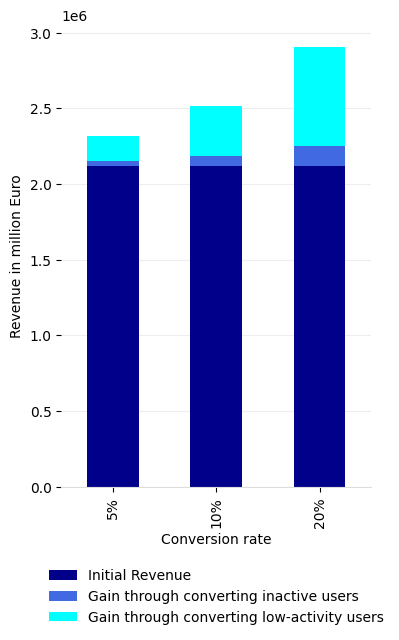

In [26]:
# Calculate potential revenue gain
total_revenue = order_volume_df['Purchase volume'].sum()
five_percent= order_volume_df['Count']*0.05
ten_percent= order_volume_df['Count']*0.1
twenty_percent= order_volume_df['Count']*0.2

order_volume_df['Average_Purchase_volume'] = order_volume_df['Purchase volume']/order_volume_df['Count']

revenue_gain_five_convert_inactive = five_percent[0]*order_volume_df['Average_Purchase_volume'][1]
revenue_gain_ten_convert_inactive = ten_percent[0]*order_volume_df['Average_Purchase_volume'][1]
revenue_gain_twenty_convert_inactive = twenty_percent[0]*order_volume_df['Average_Purchase_volume'][1]

revenue_gain_five_convert_low_to_high = five_percent[1]*order_volume_df['Average_Purchase_volume'][2] - five_percent[1]*order_volume_df['Average_Purchase_volume'][1]
revenue_gain_ten_convert_low_to_high = ten_percent[1]*order_volume_df['Average_Purchase_volume'][2] - ten_percent[1]*order_volume_df['Average_Purchase_volume'][1]
revenue_gain_twenty_convert_low_to_high = twenty_percent[1]*order_volume_df['Average_Purchase_volume'][2] - twenty_percent[1]*order_volume_df['Average_Purchase_volume'][1]

conversion_df = pd.DataFrame({'Conversion rate': ['5%', '10%', '20%'], 
                              'Initial Revenue': [total_revenue, total_revenue, total_revenue], 
                              'Gain through converting inactive users': [revenue_gain_five_convert_inactive,  revenue_gain_ten_convert_inactive, revenue_gain_twenty_convert_inactive],
                              'Gain through converting low-activity users': [revenue_gain_five_convert_low_to_high, revenue_gain_ten_convert_low_to_high, revenue_gain_twenty_convert_low_to_high]})


# Plotting and styling for presentation
plot = conversion_df.set_index('Conversion rate').plot(kind='bar', stacked=True, color=['darkblue', 'royalblue', 'cyan'], figsize = (4, 6))

plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plot.spines['left'].set_visible(False)
plot.spines['bottom'].set_color('#DDDDDD')

plot.set_axisbelow(True)
plot.yaxis.grid(True, color='#EEEEEE')
plot.xaxis.grid(False)

plot.set_ylabel('Revenue in million Euro')
plot.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15))

In [27]:
order_volume_df['Purchase volume'][2]/(order_volume_df['Purchase volume'][2]+order_volume_df['Purchase volume'][1])

0.7372974707388102

USER IDS of the segmented user groups:

In [28]:
Inactive_users = df_nopurchases['USER_ID']
Low_activity_users = df_purchases_transformed_low['USER_ID']
High_activity_users = df_purchases_transformed_high['USER_ID']


The distributions of the categorical variables don't seem to indicate additional group differences between the two groups.

The results of this analysis will be summarized and interpreted in the attached **presentation**.

Thank you for your time, investigating this notebook!